# Classifiez automatiquement des biens de consommation

# Sommaire :
 - <a href="#C1">Prétraitement des descriptions des produits</a>
 - <a href="#C2">Prétraitement des images des produits</a>
 - <a href="#C6">Fonctions communes pour l'analyse des descriptions des produits</a>
 - <a href="#C3">Extraction des features textes avec réduction de dimension et clustering</a>
 - <a href="#C4">Extraction des features images avec réduction de dimension et clustering</a>

J'importe les librairies nécessaires.

In [1]:
import pandas as pd 
import warnings
import numpy as np

#nltk
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

#pil
import PIL
from PIL import Image, ImageOps

#sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans 
from sklearn.manifold import TSNE
from sklearn import metrics, preprocessing, cluster, manifold, decomposition

#matplotlib
from matplotlib.image import imread
import matplotlib.pyplot as plt

#tensorflow
import tensorflow_hub as hub
import tensorflow as tf
import tensorflow.keras
import tensorflow_text 
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model


#transformers
import transformers
from transformers import *
from transformers import TFGenerationMixin

#keras 
from keras import Model 
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras_preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.optimizers import SGD

import seaborn as sns
import os
import gensim
import logging
logging.disable(logging.WARNING)  # disable WARNING, INFO and DEBUG logging everywhere
import cv2
import pathlib

C:\Users\eblel\anaconda\lib\site-packages\transformers\generation_tf_utils.py:24: FutureWarning: Importing `TFGenerationMixin` from `src/transformers/generation_tf_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import TFGenerationMixin` instead.
  warnings.warn(


In [2]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('words')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\eblel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\eblel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\eblel\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\eblel\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\eblel\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

 # <a name="C1"> Prétraitement des descriptions des produits</a>

### Récupération du dataset et filtre des données

J'importe mon jeu de données.

In [3]:
data = pd.read_csv("flipkart_com-ecommerce_sample_1050.csv")
print(data.shape)
data.head()

(1050, 15)


,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


Je vais garder seulement les colonnes qui m'intéressent. A savoir le nom de l'image ainsi que la description et l'arbre de catégorie.

In [4]:
data = data.loc[:, ["image", "description", "product_category_tree"]]
data.head()

,image,description,product_category_tree
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Key Features of Elegance Polyester Multicolor ...,"[""Home Furnishing >> Curtains & Accessories >>..."
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,Specifications of Sathiyas Cotton Bath Towel (...,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T..."
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,Key Features of Eurospa Cotton Terry Face Towe...,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T..."
3,d4684dcdc759dd9cdf41504698d737d8.jpg,Key Features of SANTOSH ROYAL FASHION Cotton P...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>..."
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,Key Features of Jaipur Print Cotton Floral Kin...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>..."


Je veux garder seulement la première partie de l'arbre de catégorie pour avoir les catégories principales.

In [5]:
data['product_category'] = data["product_category_tree"].apply(lambda x : x.split(">>")[0].split('"')[1])
data["product_category"] = data["product_category"].apply(lambda x : x[:-1])
data = data.drop(["product_category_tree"], axis=1)
data.head()



,image,description,product_category
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Key Features of Elegance Polyester Multicolor ...,Home Furnishing
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,Specifications of Sathiyas Cotton Bath Towel (...,Baby Care
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,Key Features of Eurospa Cotton Terry Face Towe...,Baby Care
3,d4684dcdc759dd9cdf41504698d737d8.jpg,Key Features of SANTOSH ROYAL FASHION Cotton P...,Home Furnishing
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,Key Features of Jaipur Print Cotton Floral Kin...,Home Furnishing


J'analyse la répartition des catégories.

In [6]:
data["product_category"].value_counts()

Home Furnishing               150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Kitchen & Dining              150
Beauty and Personal Care      150
Computers                     150
Name: product_category, dtype: int64

Je vérifie si mon DataFrame contient des valeurs manquantes.

In [7]:
data.isnull().sum()

image               0
description         0
product_category    0
dtype: int64

Je vérifie si mon DataFrame contient des valeurs doublées.

In [8]:
data.duplicated(keep = "last")

0       False
1       False
2       False
3       False
4       False
        ...  
1045    False
1046    False
1047    False
1048    False
1049    False
Length: 1050, dtype: bool

### Nettoyage du texte

Je commence par faire un tokenizer qui permet de faire un premier nettoyage des phrases et qui sépare les phrases en liste de mots.

In [9]:
def tokenizer(sentence):
    sentence_clean = sentence.replace('-', ' ').replace('+', ' ').replace('/', ' ').replace('#', ' ')
    word_tokens = word_tokenize(sentence_clean)
    return word_tokens

Je fais ensuite un stop word qui permet de faire un deuxième nettoyage en supprimant les mots les plus courants en anglais et des signes de ponctuations. Il permet aussi de supprimer les mots qui ont moins de 2 lettres.

In [10]:
stop = list(set(stopwords.words('english'))) + ['[', ']', ',', '.', ':', '?', '(', ')', '!']

def stop_word(list_words) :
    filtered_w = [w for w in list_words if not w in stop]
    filtered_w2 = [w for w in filtered_w if len(w) > 2]
    return filtered_w2

Je mets toutes les lettres en minuscule.

In [11]:
def lower_start_fct(list_words) :
    lw = [w.lower() for w in list_words]
    return lw

Je fais un lemmatizer qui permet de garder la base des mots.

In [12]:
def lemmatizer(list_words) :
    lemmatizer = WordNetLemmatizer()
    lem_w = [lemmatizer.lemmatize(w) for w in list_words]
    return lem_w

# <a name="C2"> Prétraitement des images des produits </a>

Je commence par créer des labels des photos à partir du nom des catégories.

In [13]:
le = preprocessing.LabelEncoder()
data["label"] = le.fit_transform(data["product_category"])
data.head()

,image,description,product_category,label
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Key Features of Elegance Polyester Multicolor ...,Home Furnishing,4
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,Specifications of Sathiyas Cotton Bath Towel (...,Baby Care,0
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,Key Features of Eurospa Cotton Terry Face Towe...,Baby Care,0
3,d4684dcdc759dd9cdf41504698d737d8.jpg,Key Features of SANTOSH ROYAL FASHION Cotton P...,Home Furnishing,4
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,Key Features of Jaipur Print Cotton Floral Kin...,Home Furnishing,4


J'analyse la répartition des labels.

In [14]:
data.groupby("label").count()

,image,description,product_category
label,,,
0,150,150,150
1,150,150,150
2,150,150,150
3,150,150,150
4,150,150,150
5,150,150,150
6,150,150,150


J'affiche des exemples d'images par label. Je commence par définir une variable qui contient le chemin du dossier qui contient toutes les images.

In [15]:
path = pathlib.PureWindowsPath(r"C:\Users\eblel\Desktop\Openclassroom\Projet 6\Projet\Flipkart\Images\ ")
path = str(path)
path = path[:-1]
path

'C:\\Users\\eblel\\Desktop\\Openclassroom\\Projet 6\\Projet\\Flipkart\\Images\\'

Home Furnishing


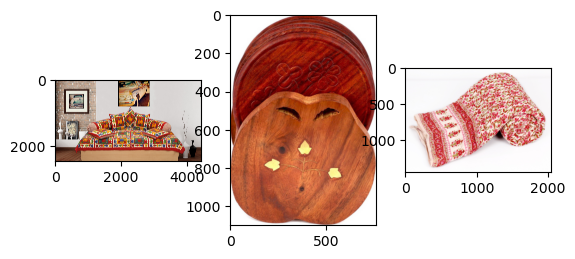

Baby Care


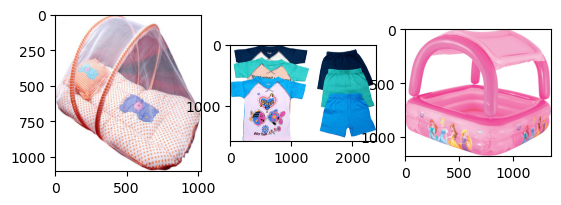

Watches


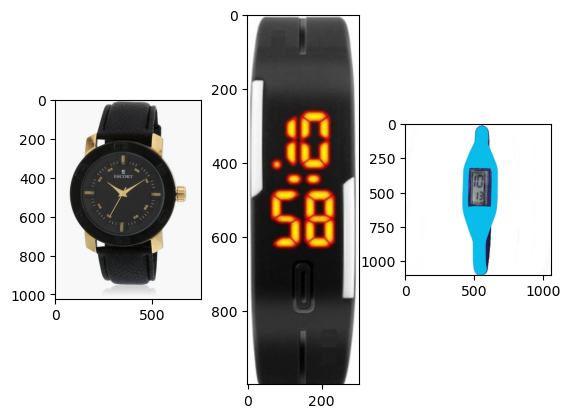

Home Decor & Festive Needs


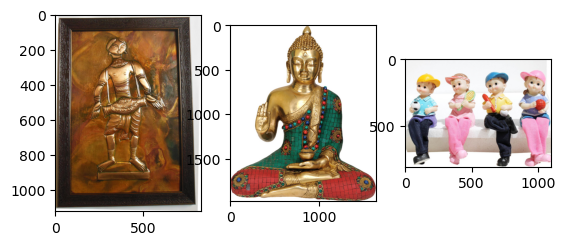

Kitchen & Dining


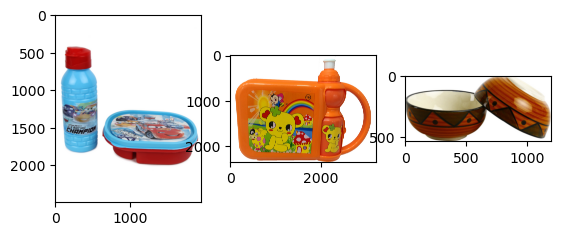

Beauty and Personal Care


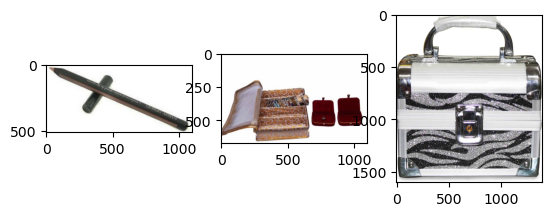

Computers


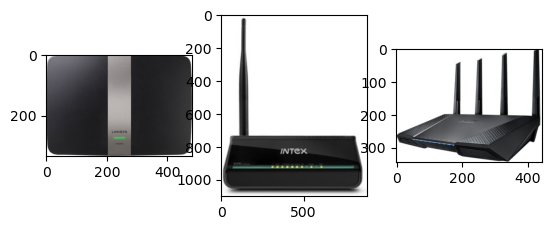

In [16]:
def list_fct(name) :
    list_image_name = [data["image"][i] for i in range(len(data)) if data["product_category"][i] == name]
    return list_image_name

list_home_furnishing = [data["image"][i] for i in range(len(data)) if data["product_category"][i] == "Home Furnishing"]
list_baby_care = [data["image"][i] for i in range(len(data)) if data["product_category"][i] == "Baby Care"]
list_watches = [data["image"][i] for i in range(len(data)) if data["product_category"][i] == "Watches"]
list_home_decor_and_festive_needs = [data["image"][i] for i in range(len(data)) if data["product_category"][i] == "Home Decor & Festive Needs"]
list_kitchen_and_dining = [data["image"][i] for i in range(len(data)) if data["product_category"][i] == "Kitchen & Dining"]
list_beauty_and_personal_care = [data["image"][i] for i in range(len(data)) if data["product_category"][i] == "Beauty and Personal Care"]
list_computers = [data["image"][i] for i in range(len(data)) if data["product_category"][i] == "Computers"]

list_labels = ["Home Furnishing", "Baby Care", "Watches", "Home Decor & Festive Needs", "Kitchen & Dining",
               "Beauty and Personal Care", "Computers"]

for name in list_labels :
    print(name)
    for i in range(3):
        plt.subplot(130 + 1 + i)
        filename = path + list_fct(name)[i+10]
        image = imread(filename)
        plt.imshow(image)
    plt.show()

Je convertis mes images en gris et j'égalise les histogrammes. Puis je crée des descripteurs pour chaque image.
J'ai une liste de descripteurs par image qui sera utilisée pour réaliser les histogrammes par image. Et une liste de descripteurs pour l'ensemble des images qui sera utilisée pour créer les clusters des descripteurs.

In [17]:
sift_keypoints = []
sift = cv2.xfeatures2d.SIFT_create(500)

for image_num in range(len(data["image"])) :
    if image_num%100 == 0 : print(image_num)
    image = cv2.imread(path+data["image"][image_num],0) # convert in gray
    equ = cv2.equalizeHist(image)   # equalize image histogram
    res = cv2.fastNlMeansDenoising(equ)  # denoising 
    kp, des = sift.detectAndCompute(res, None)
    sift_keypoints.append(des)

sift_keypoints_by_img = np.asarray(sift_keypoints)
sift_keypoints_all    = np.concatenate(sift_keypoints_by_img, axis=0)

print()
print("Nombre de descripteurs : ", sift_keypoints_all.shape)

0
100
200
300
400
500
600
700
800
900
1000


C:\Users\eblel\AppData\Local\Temp\ipykernel_20224\3901999760.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sift_keypoints_by_img = np.asarray(sift_keypoints)



Nombre de descripteurs :  (517106, 128)


# <a name="C6"> Fonctions communes pour l'analyse des descriptions des produits </a>

Je crée une fonction qui aggrège les étapes de préparation des descriptions pour qu'elles soient utilisables pour le comptage simple et le tf-idf.

In [18]:
def bow_fct(description) :
    word_tokens = tokenizer(description)
    sw = stop_word(word_tokens)
    lw = lower_start_fct(sw)
    lem_w = lemmatizer(lw)    
    description = ' '.join(lw)
    return description

data['sentence_bow'] = data['description'].apply(lambda x : bow_fct(x))
data.head()

,image,description,product_category,label,sentence_bow
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Key Features of Elegance Polyester Multicolor ...,Home Furnishing,4,key features elegance polyester multicolor abs...
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,Specifications of Sathiyas Cotton Bath Towel (...,Baby Care,0,specifications sathiyas cotton bath towel bath...
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,Key Features of Eurospa Cotton Terry Face Towe...,Baby Care,0,key features eurospa cotton terry face towel s...
3,d4684dcdc759dd9cdf41504698d737d8.jpg,Key Features of SANTOSH ROYAL FASHION Cotton P...,Home Furnishing,4,key features santosh royal fashion cotton prin...
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,Key Features of Jaipur Print Cotton Floral Kin...,Home Furnishing,4,key features jaipur print cotton floral king s...


Je crée une fonction qui aggrège les étapes de préparations des descriptions pour qu'elles soient utilisables pour Deep Learning (BERT et USE).

In [19]:
def dl_fct(description) :
    word_tokens = tokenizer(description)
    lw = lower_start_fct(word_tokens)
    description = ' '.join(lw)
    return description

data['sentence_dl'] = data['description'].apply(lambda x : dl_fct(x))
data.head()

,image,description,product_category,label,sentence_bow,sentence_dl
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Key Features of Elegance Polyester Multicolor ...,Home Furnishing,4,key features elegance polyester multicolor abs...,key features of elegance polyester multicolor ...
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,Specifications of Sathiyas Cotton Bath Towel (...,Baby Care,0,specifications sathiyas cotton bath towel bath...,specifications of sathiyas cotton bath towel (...
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,Key Features of Eurospa Cotton Terry Face Towe...,Baby Care,0,key features eurospa cotton terry face towel s...,key features of eurospa cotton terry face towe...
3,d4684dcdc759dd9cdf41504698d737d8.jpg,Key Features of SANTOSH ROYAL FASHION Cotton P...,Home Furnishing,4,key features santosh royal fashion cotton prin...,key features of santosh royal fashion cotton p...
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,Key Features of Jaipur Print Cotton Floral Kin...,Home Furnishing,4,key features jaipur print cotton floral king s...,key features of jaipur print cotton floral kin...


Je crée une fonction qui calcul le Tsne, qui détermine les clusters et qui calcul l'ARI pour calculer la similarité entre les clusters et les catégories réelles.

In [20]:
categ = list(set(data["product_category"]))
categ_num = [(1-categ.index(data.iloc[i]["product_category"])) for i in range(len(data))]

def ARI_fct(features) :
    num_labels = len(categ)
    tsne = TSNE(n_components = 2, perplexity = 53, n_iter = 2000, init = 'random', learning_rate = 200, random_state=42)
    X_tsne = tsne.fit_transform(features)
    
    cls = KMeans(n_clusters = num_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)
    ARI = np.round(metrics.adjusted_rand_score(categ_num, cls.labels_),4)
    print("ARI : ", ARI) 
    return ARI, X_tsne, cls.labels_

Je crée une fonction de visulatisation du Tsne selon les vraies catégories et les clusters.

In [21]:
def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI) :
    fig = plt.figure(figsize=(15,6))
    
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c = categ_num, cmap='Set1')
    ax.legend(handles = scatter.legend_elements()[0], labels = categ, loc = "best", title = "Categorie")
    plt.title('Représentation des articles par catégories réelles')
    
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c = labels, cmap='Set1')
    ax.legend(handles = scatter.legend_elements()[0], labels = set(labels), loc = "best", title = "Clusters")
    plt.title('Représentation des articles par clusters')

    plt.show()
    print("ARI : ", ARI)

# <a name="C3"> Extraction des features textes avec réduction de dimension et clustering </a>

### Bag of words : comptage simple

J'applique le comptage simple.

In [22]:
cvect = CountVectorizer(stop_words = 'english', max_df = 0.95, min_df = 1)
cv_fit_trans = cvect.fit_transform(data["sentence_bow"])

J'utilise la fonction définie plus haut qui permet de caluler le score de similarité entre les clusters. 

In [23]:
print("CountVectorizer : ")
ARI, X_tsne, labels = ARI_fct(cv_fit_trans)

CountVectorizer : 
ARI :  0.3874


J'utilise le fonction définie plus haut pour comparer les vraies catégories et les clusters.

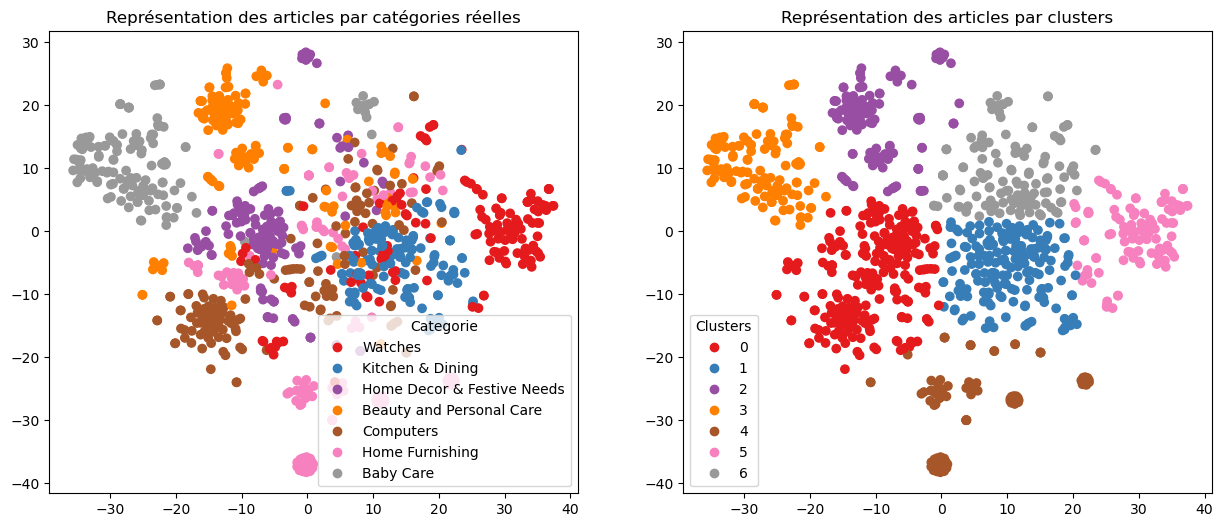

ARI :  0.3874


In [24]:
 TSNE_visu_fct(X_tsne, categ_num, labels, ARI)

### Bag of words : Tf-idf

J'applique le modèle de Tf-idf.

In [25]:
ctf = TfidfVectorizer(stop_words = 'english', max_df = 0.95, min_df = 1)
ctf_fit_trans = ctf.fit_transform(data["sentence_bow"])

J'utilise la fonction définie plus haut qui permet de caluler le score de similarité entre les clusters. 

In [26]:
print("Tf-idf : ")
ARI, X_tsne, labels = ARI_fct(ctf_fit_trans)

Tf-idf : 
ARI :  0.472


J'utilise le fonction définie plus haut pour comparer les vraies catégories et les clusters.

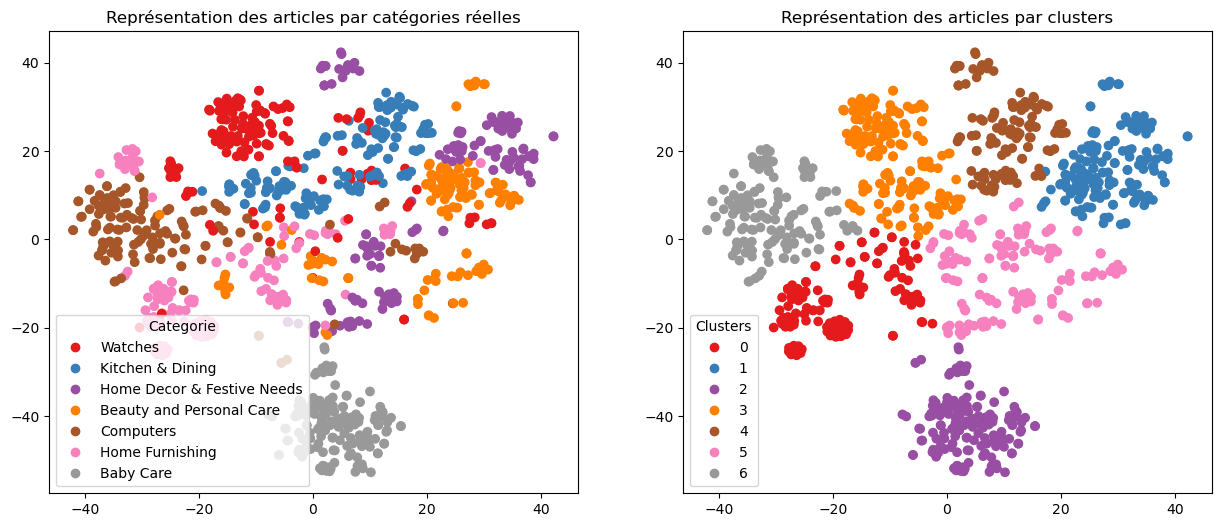

ARI :  0.472


In [27]:
 TSNE_visu_fct(X_tsne, categ_num, labels, ARI)

### Word2Vec 

In [28]:
sentences = data['sentence_bow'].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

Je crée la matrice d'embedding.

In [29]:
print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(min_count = 1, window = 5, vector_size = 300, seed=42, workers=1)
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples = w2v_model.corpus_count, epochs = 100)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Build & train Word2Vec model ...
Vocabulary size: 5098
Word2Vec trained


Je prépare les sentences.

In [30]:
print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences), maxlen = 100, padding='post') 
                                                   
num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 5099


In [31]:
print("Create Embedding matrix ...")
w2v_size = 300
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0
    
for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]
            
word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (5099, 300)


In [32]:
maxlen = 100
input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
word_input=Input(shape=(maxlen,),dtype='float64')  
word_embedding=Embedding(input_dim=vocab_size,output_dim=w2v_size,weights = [embedding_matrix],
                         input_length=maxlen)(word_input)
word_vec=GlobalAveragePooling1D()(word_embedding)  
embed_model = Model([word_input],word_vec)

embed_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 300)          1529700   
                                                                 
 global_average_pooling1d (G  (None, 300)              0         
 lobalAveragePooling1D)                                          
                                                                 
Total params: 1,529,700
Trainable params: 1,529,700
Non-trainable params: 0
_________________________________________________________________


In [33]:
embeddings = embed_model.predict(x_sentences)
embeddings.shape

33/33 [==============================] - 0s 3ms/step


(1050, 300)

In [34]:
ARI, X_tsne, labels = ARI_fct(embeddings)

ARI :  0.3158


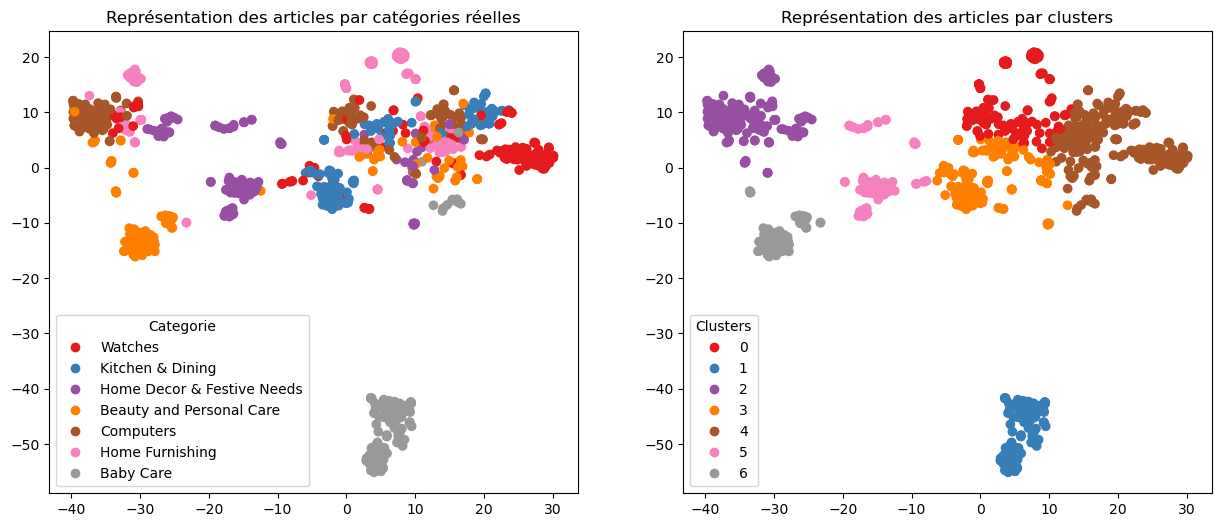

ARI :  0.3158


In [35]:
TSNE_visu_fct(X_tsne, categ_num, labels, ARI)

### BERT

In [36]:
os.environ["TF_KERAS"] = "1"

Je définis une fonction de préparation des sentences.

In [37]:
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot


Je définis une fonction de création de features.

In [38]:
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)


    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                      bert_tokenizer, max_length)
        
        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
     
    return features_bert, last_hidden_states_tot

BERT HuggingFace

'bert-base-uncased'

In [39]:
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)
sentences = data['sentence_dl'].to_list()

Création des features.

In [40]:
features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, max_length, batch_size, mode='HF')

1/1 [==============================] - 1s 653ms/step


In [41]:
ARI, X_tsne, labels = ARI_fct(features_bert)

ARI :  0.3204


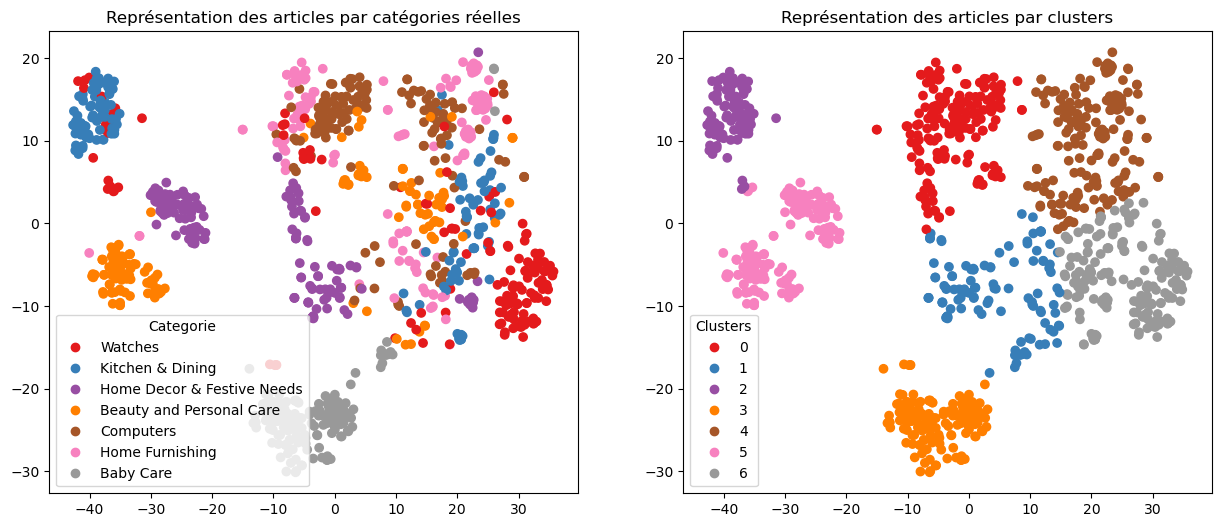

ARI :  0.3204


In [42]:
TSNE_visu_fct(X_tsne, categ_num, labels, ARI)

BERT hub Tensorflow

In [53]:
os.environ["TFHUB_CACHE_DIR"] = "some_dir"

In [54]:
model_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
bert_layer = hub.KerasLayer(model_url, trainable=True)

In [55]:
sentences = data['sentence_dl'].to_list()

In [56]:
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = bert_layer

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='TFhub')

In [57]:
ARI, X_tsne, labels = ARI_fct(features_bert)

ARI :  0.3207


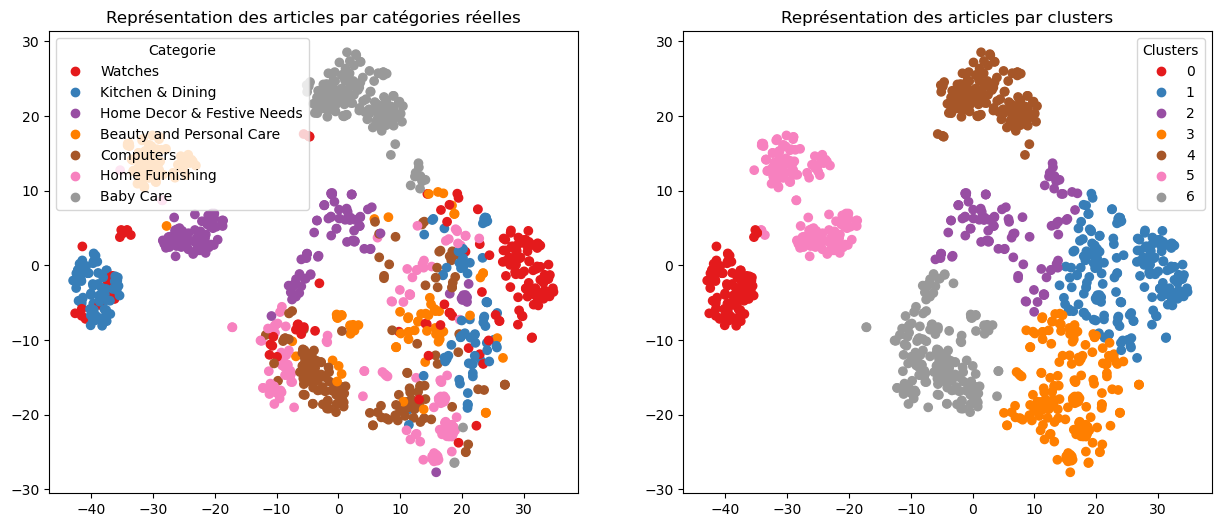

ARI :  0.3207


In [58]:
TSNE_visu_fct(X_tsne, categ_num, labels, ARI)

### USE

In [59]:
def feature_USE_fct(sentences, b_size) :
    batch_size = b_size

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))
    return features

In [60]:
batch_size = 10
sentences = data['sentence_dl'].to_list()

In [61]:
os.environ['TFHUB_CACHE_DIR'] = '/home/user/workspace/tf_cache'

In [62]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [63]:
 features_USE = feature_USE_fct(sentences, batch_size)

In [64]:
ARI, X_tsne, labels = ARI_fct(features_USE)

ARI :  0.4119


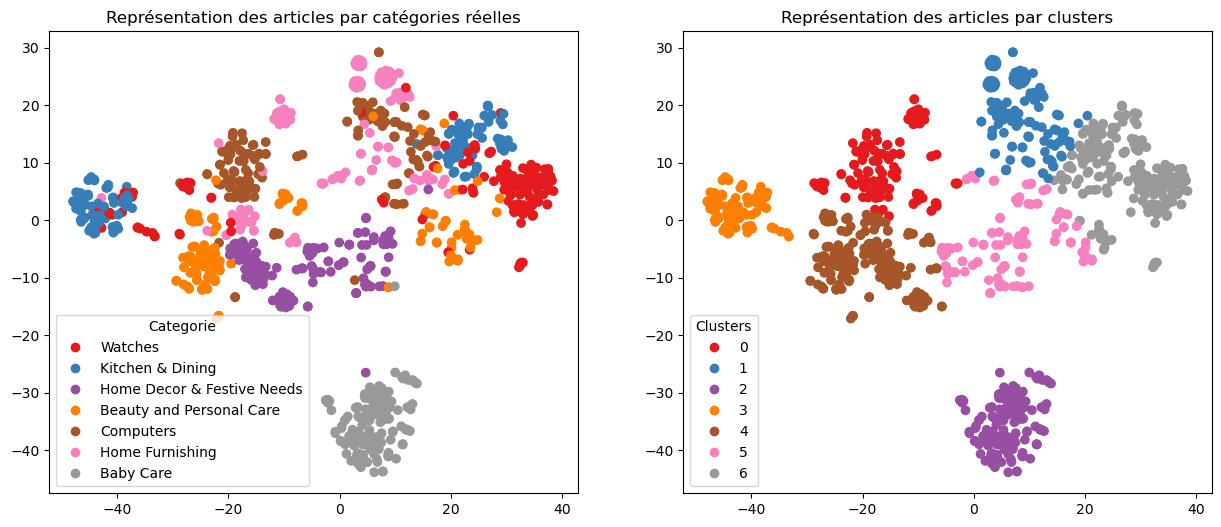

ARI :  0.4119


In [65]:
TSNE_visu_fct(X_tsne, categ_num, labels, ARI)

# <a name="C4"> Extraction des features images avec réduction de dimension et clustering </a>

### SIFT 

Je vais créer des clusters de descripteurs.
Je commence par déterminer le nombre de cluster, je choisi la racine carrée du nombre total de descripteurs.

In [66]:
k = int(round(np.sqrt(len(sift_keypoints_all)),0))
print("Nombre de clusters estimés : ", k)

Nombre de clusters estimés :  719


J'applique le Kmeans à l'aide de MiniBatchKmeans pour plus de rapidité.

In [67]:
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
kmeans.fit(sift_keypoints_all)

C:\Users\eblel\anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


MiniBatchKMeans(init_size=2157, n_clusters=719, random_state=0)

Je crée les histogrammes, c'est-à-dire les features.

In [68]:
def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : 
        print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist

Je crée la matrice des histogrammes.

In [69]:
hist_vectors=[]

for i, image_desc in enumerate(sift_keypoints_by_img) :
    if i%100 == 0 : print(i)  
    hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
    hist_vectors.append(hist) #histogram is the feature vector

im_features = np.asarray(hist_vectors)

0
100
200
300
400
500
600
700
800
900
1000


Je passe à la réduction de dimension PCA. La réduction PCA permet de créer des features décorrélées entre elles et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (99%).
On aura ainsi une meilleure séparation des données via le T-SNE et une réduction du temps de traitement de ce dernier.

In [70]:
print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 719)
Dimensions dataset après réduction PCA :  (1050, 497)


Ensuite la réduction de dimension T-SNE à 2 composantes pour un affichae en 2D des images.

In [71]:
tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = data["product_category"]
print(df_tsne.shape)

C:\Users\eblel\anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(1050, 3)


Je fais l'analyse des mesures, c'est-à-dire la similarité entre les catégories et les clusters.
Je créer des clusters à partir du T-SNE.

In [72]:
cls = cluster.KMeans(n_clusters=7, random_state=6)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

(1050, 4)


J'affiche les images selon les clusters et je calcule l'ARI de similarité catégories images/clusters.

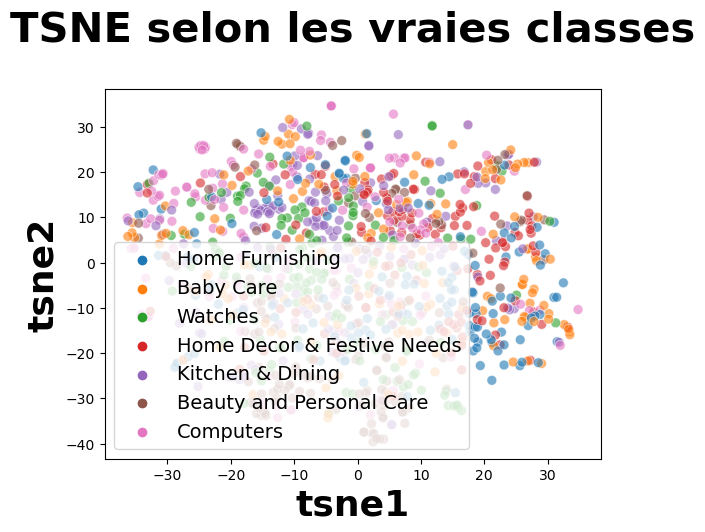

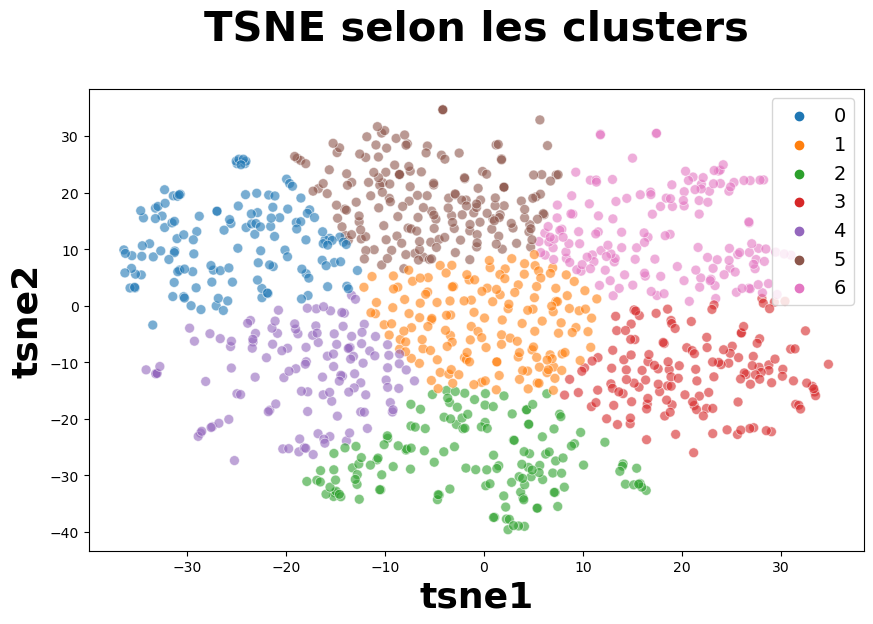

ARI :  0.06361489733071644


In [73]:
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 


plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels = data["label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

### CNN Transfert Learning

J'utilise VGG16 pré-entrainé sur ImageNet.

In [78]:
model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

In [79]:
path = pathlib.PureWindowsPath(r"C:\Users\eblel\Desktop\Openclassroom\Projet 6\Projet\Flipkart\Images\ ")
path = str(path)
path = path[:-1]
path

'C:\\Users\\eblel\\Desktop\\Openclassroom\\Projet 6\\Projet\\Flipkart\\Images\\'

In [80]:
all_features = []
for i in data["image"]:
    img = load_img(path + i, target_size = (224, 224))
    img = img_to_array(img)
    img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
    img = preprocess_input(img)
    features = model.predict(img)
    all_features.append(np.array(features).flatten())

1/1 [==============================] - 0s 157ms/step


1/1 [==============================] - 0s 158ms/step


1/1 [==============================] - 0s 157ms/step


C:\Users\eblel\anaconda\lib\site-packages\PIL\Image.py:3035: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


1/1 [==============================] - 0s 225ms/step


1/1 [==============================] - 0s 227ms/step


In [81]:
all_features = np.array(all_features)

In [82]:
all_features.shape

(1050, 25088)

In [83]:
print("Dimensions dataset avant réduction PCA : ", all_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(all_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 25088)
Dimensions dataset après réduction PCA :  (1050, 940)


In [84]:
tsne = manifold.TSNE(n_components=2, perplexity=15, 
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = data["product_category"]
print(df_tsne.shape)

C:\Users\eblel\anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(1050, 3)


In [85]:
cls = cluster.KMeans(n_clusters=7, random_state=6)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

(1050, 4)


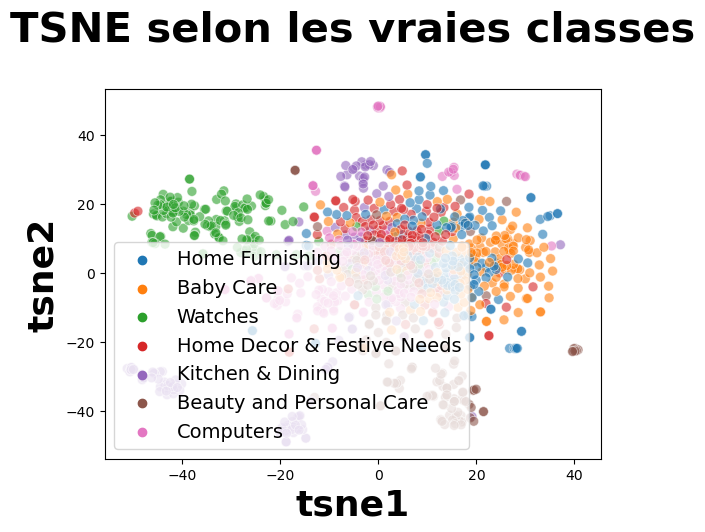

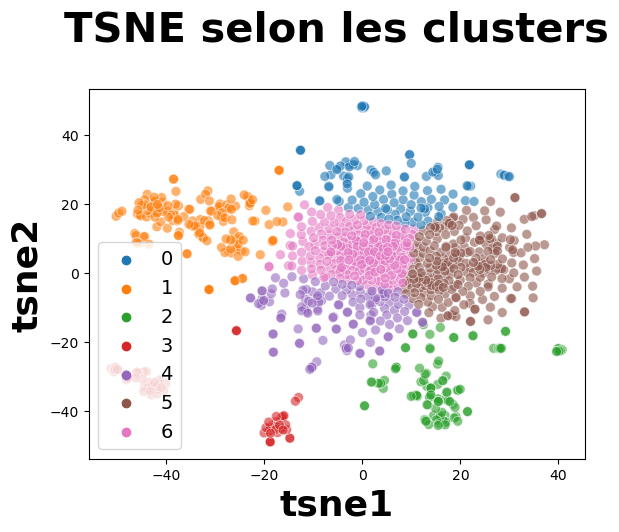

ARI :  0.3103416808660973


In [86]:
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels = data["label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))